# Movie Information ChatBot

## Set-up environment

In [1]:
import os
import pandas as pd

In [2]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [3]:
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [4]:
# Embedding facilities
from langchain.embeddings import HuggingFaceEmbeddings
# Pipelines
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

## Data Collection

In [5]:
df = pd.read_csv('Data/title.basics.tsv', sep='\t', low_memory=False)

In [6]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10790736 entries, 0 to 10790735
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 740.9+ MB


In [8]:
df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [9]:
movie_df = df[df['titleType'].isin(['short', 'movie', 'tvMovie'])]
movie_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10790676,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama
10790686,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,\N,49,Documentary
10790687,tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,0,2019,\N,\N,Short
10790691,tt9916764,short,38,38,0,2018,\N,\N,Short


In [10]:
title_df = movie_df[['originalTitle']]
title_df

,originalTitle
0,Carmencita
1,Le clown et ses chiens
2,Pauvre Pierrot
3,Un bon bock
4,Blacksmith Scene
...,...
10790676,6 Gunn
10790686,Chico Albuquerque - Revelações
10790687,Pretty Pretty Black Girl
10790691,38


In [11]:
title_df.isnull().sum()

originalTitle    5
dtype: int64

In [12]:
title_df = title_df.dropna()

In [13]:
title_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1823035 entries, 0 to 10790734
Data columns (total 1 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   originalTitle  object
dtypes: object(1)
memory usage: 27.8+ MB


In [14]:
title_df.isnull().sum()

originalTitle    0
dtype: int64

### Load Wikipedia

In [15]:
import loadlib
from loadlib import loadWiki

In [16]:
import importlib 
importlib.reload(loadlib)

<module 'loadlib' from '/Users/mariamcnally/Desktop/SW2Semester/AI/AI_exam/loadlib.py'>

In [17]:
# Collect all here
documents = []

In [18]:
subject = 'Film'

In [19]:
lang = 'en'

In [20]:
docs = loadlib.loadWiki(subject, lang, 2)
documents.extend(docs)

In [21]:
from tqdm import tqdm

In [22]:
titles_to_process = title_df['originalTitle'].iloc[:1000]

In [23]:
for title in tqdm(titles_to_process, desc="Processing titles"):
    docs = loadlib.loadWiki(title, lang, 2)
    documents.extend(docs)

Processing titles: 100%|████████████████████████| 10/10 [00:28<00:00,  2.82s/it]


In [24]:
len(documents)

22

## Chunking

In [25]:
import utils
from utils import chunkDocs, langDetect, wordCloud

In [26]:
import importlib 
importlib.reload(utils)

<module 'utils' from '/Users/mariamcnally/Desktop/SW2Semester/AI/AI_exam/utils.py'>

In [27]:
splits = utils.chunkDocs(documents, 350)  

In [28]:
len(splits)

284

In [29]:
split_df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])

In [30]:
split_df.sample(3)

,page_content,metadata,type
283,"(page_content, Le Débarquement du congrès de p...","(metadata, {'title': 'Auguste and Louis Lumièr...","(type, Document)"
220,"(page_content, example of a feature-length dra...","(metadata, {'title': 'Miss Jerry', 'summary': ...","(type, Document)"
30,"(page_content, Bea that her father will be all...","(metadata, {'title': 'IF (film)', 'summary': '...","(type, Document)"


## Data Visualisation

In [31]:
im, longstring = utils.wordCloud(split_df, 'page_content')

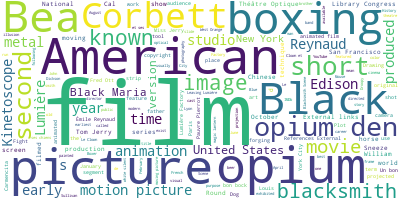

In [32]:
im

## Embeddings

In [33]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [34]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Storing the embeddings in vector database

In [35]:
#!pip install chromadb

In [36]:
db = Chroma.from_documents(splits, embeddings)

In [37]:
persist_directory = './examData/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

In [38]:
vectordb._collection.count()

41091

## Similarity Search

In [39]:
query = 'what is a movie?'

In [40]:
answer = vectordb.similarity_search(query, k=3)
for d in answer:
    print(d.page_content)

A film (British English) – also called a movie (American English), motion picture, moving picture, picture, photoplay or (slang) flick – is a work of visual art that simulates experiences and otherwise communicates ideas, stories, perceptions, feelings, beauty, or atmosphere through the use of moving images. These images are generally accompanied
by sound and, more rarely, other sensory stimulations. The word "cinema", short for cinematography, is often used to refer to filmmaking and the film industry, and the art form that is the result of it.
Many other terms exist for an individual motion-picture, including "picture", "picture show", "moving picture", "photoplay", and "flick". The most common term in the United States is "movie", while in Europe, "film" is preferred. Archaic terms include "animated pictures" and "animated photography".


In [41]:
for d in answer:
    print(d.metadata)

{'source': 'https://en.wikipedia.org/wiki/Film', 'summary': 'A film (British English) – also called a movie (American English), motion picture, moving picture, picture, photoplay or (slang) flick – is a work of visual art that simulates experiences and otherwise communicates ideas, stories, perceptions, feelings, beauty, or atmosphere through the use of moving images. These images are generally accompanied by sound and, more rarely, other sensory stimulations. The word "cinema", short for cinematography, is often used to refer to filmmaking and the film industry, and the art form that is the result of it.', 'title': 'Film'}
{'source': 'https://en.wikipedia.org/wiki/Film', 'summary': 'A film (British English) – also called a movie (American English), motion picture, moving picture, picture, photoplay or (slang) flick – is a work of visual art that simulates experiences and otherwise communicates ideas, stories, perceptions, feelings, beauty, or atmosphere through the use of moving image

## Information Retrieval

In [42]:
q1 = 'What is the first ever film?'

In [43]:
q2 = 'What is the worlds best movie?'

In [44]:
q3 = 'Who directed the film Carmencita?'

In [45]:
q4 = 'Which movies has Charlie Chaplin stared in?'

In [46]:
answer = vectordb.max_marginal_relevance_search(q1, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

1887 – Man Walking Around a Corner, directed by French inventor Louis Le Prince. The oldest known film. Although according to David Wilkinson's 2015 documentary The First Film it's not film, but a series of photographs, 16 in all, each taken from one of the lens from Le Prince's camera. Pictures from the film were sent in a letter dated 18 August
== Critical analysis ==
John Barnes has written that "this could be considered as the first modern film", describing it as "far ahead of its time as regards film technique".


== References ==
Citations


In [47]:
answer = vectordb.max_marginal_relevance_search(q2, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

American Movies.
The film holds the rare distinction of being among the 19th century films voted for in the British Film Institute's decennial Sight & Sound poll: director Patrick Keiller ranked it one of the 10 greatest motion pictures ever made.


In [48]:
answer = vectordb.max_marginal_relevance_search(q3, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

According to film historian Charles Musser, Carmencita was the first woman to appear in a modern motion picture made for commercial purposes and may have been the first woman to appear in a motion picture within the United States. In the film she is recorded going through a routine she had been performing at Koster and Bial's Music Hall in New
pseudo-documentary Las Hurdes: Tierra Sin Pan (1933). In 1933 it was responsible for filming seventeen motion pictures and in 1934, twenty-one. The most notable success was Paloma Fair (Benito Perojo, 1935). They were also responsible for Don Quijote de la Mancha (Rafael Gil, 1947), the most elaborate version of the Cervantes classic up to that


In [49]:
answer = vectordb.max_marginal_relevance_search(q4, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

Arbuckle, Charlie Chaplin, Mary Astor and Pola Negri, but no footage exists.
Arbuckle, Charlie Chaplin, Mary Astor and Pola Negri, but no footage exists.


## Large Language Model

In [50]:
# Disable parallelism for tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [51]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [52]:
!ollama list

NAME          	ID          	SIZE  	MODIFIED           
mistral:latest	2ae6f6dd7a3d	4.1 GB	About a minute ago	


In [53]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use five sentences maximum. Keep the answer as concise as possible. 
Always say "thanks for asking!" at the end of the answer. 

{context}

Question: {question}

Helpful Answer:
"""

In [54]:
prompt = PromptTemplate.from_template(template)
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [55]:
result1 = chain({"query": q1})
result1["result"]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 The first ever film was created by Frenchman Émile Reynaud with his Praxinoscope device, which he used to project animated films up to 16 frames long on October 28, 1892, at Musée Grévin in Paris, France. However, the oldest known moving image is "Man Walking Around a Corner" (1887) by Louis Le Prince, which was not actually film but a series of photographs. Thanks for asking!

' The first ever film was created by Frenchman Émile Reynaud with his Praxinoscope device, which he used to project animated films up to 16 frames long on October 28, 1892, at Musée Grévin in Paris, France. However, the oldest known moving image is "Man Walking Around a Corner" (1887) by Louis Le Prince, which was not actually film but a series of photographs. Thanks for asking!'

In [56]:
result2 = chain({"query": q2})
result2["result"]

 The question asks for "the world's best movie," which is subjective as movie preferences vary greatly among people. However, considering your context, the film you described, often referred to as "The Film," holds significant importance in the history of cinema and was ranked one of the 10 greatest motion pictures ever made by director Patrick Keiller. But it's important to note that other influential figures might rank different films higher. Thanks for asking!

' The question asks for "the world\'s best movie," which is subjective as movie preferences vary greatly among people. However, considering your context, the film you described, often referred to as "The Film," holds significant importance in the history of cinema and was ranked one of the 10 greatest motion pictures ever made by director Patrick Keiller. But it\'s important to note that other influential figures might rank different films higher. Thanks for asking!'

In [57]:
result3 = chain({"query": q3})
result3["result"]

 The film featuring Carmencita, referred to as your context suggests, wasn't specified to have a director in the provided information. However, it was based on her dance routine from Koster and Bial's Music Hall performance of "Carmen" under La Argentina's guidance.

' The film featuring Carmencita, referred to as your context suggests, wasn\'t specified to have a director in the provided information. However, it was based on her dance routine from Koster and Bial\'s Music Hall performance of "Carmen" under La Argentina\'s guidance.'

In [58]:
result4 = chain({"query": q4})
result4["result"]

 Charlie Chaplin starred in many films throughout his career, including "The Kid" (1921), "The Gold Rush" (1925), and "City Lights" (1931). However, the specific movie where he co-starred with Arbuckle, Mary Astor, and Pola Negri remains unknown as no footage from that film exists. Thanks for asking!

' Charlie Chaplin starred in many films throughout his career, including "The Kid" (1921), "The Gold Rush" (1925), and "City Lights" (1931). However, the specific movie where he co-starred with Arbuckle, Mary Astor, and Pola Negri remains unknown as no footage from that film exists. Thanks for asking!'

In [59]:
import pickle

In [60]:
# Save the model using pickle (optional)
pickle_file = "chatbot_model.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(llm, file)